In [6]:
import os
import numpy as np
import torch
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import torch 
import time
from audioldm import build_model
from audioldm.latent_diffusion.ddim import DDIMSampler
from audioldm.pipeline import duration_to_latent_t_size
from utils.utils import *

sr = 16000

#test
#Saturn is working
#Saturn is working
#Saturn is working

In [7]:

model = build_model(model_name="audioldm-m-full")

torch.cuda.reset_peak_memory_stats()
torch.cuda.synchronize()

modelmem = torch.cuda.memory_allocated() / (1024 * 1024) 

print(f"{modelmem} MiB")
print(torch.cuda.memory_summary())

Load AudioLDM: %s audioldm-m-full
DiffusionWrapper has 415.95 M params.


/home/manish/Ayush/audioldm/ldmenv/lib/python3.8/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 23.60 GiB of which 10.38 MiB is free. Process 1809613 has 13.62 GiB memory in use. Including non-PyTorch memory, this process has 9.78 GiB memory in use. Of the allocated memory 9.44 GiB is allocated by PyTorch, and 38.45 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
prompt = "Wind blowing through the leaves of a dense forest."
duration = 60.0  

In [ ]:
model.cond_stage_model.embed_mode = "text"
text_list = [prompt] 

text_emb = model.get_learned_conditioning(text_list)

unconditional_text = [""] 
unconditional_embedding = model.get_learned_conditioning(unconditional_text)

In [ ]:
sampler = DDIMSampler(model)

torch.cuda.synchronize()
latent_size = duration_to_latent_t_size(duration)
shape = [model.channels, latent_size, model.latent_f_size]
z = torch.randn([1] + shape).to(model.device)

ddim_steps = 200
ddim_eta = 0.1
unconditional_guidance_scale = 3.0

memory_before_diffusion = torch.cuda.memory_allocated() / (1024 * 1024)
torch.cuda.reset_peak_memory_stats()

# Run diffusion
start_time = time.time()
with torch.no_grad(): 
    samples, _ = sampler.sample(
        S=ddim_steps,  
        batch_size=1,
        shape=shape,
        conditioning=text_emb,
        unconditional_conditioning=unconditional_embedding,
        unconditional_guidance_scale=unconditional_guidance_scale,
        eta=ddim_eta,
        verbose=False,
        x_T=z
    )
torch.cuda.synchronize()

# Get time and memory
diffusion_time = time.time() - start_time
isolated_peak = torch.cuda.max_memory_allocated() / (1024 * 1024)  # Convert to MiB
current_memory = torch.cuda.memory_allocated() / (1024 * 1024)  # Convert to MiB
isolated_cost = isolated_peak - memory_before_diffusion

print(f"DIFFUSION ISOLATED PEAK: {isolated_peak:.1f} MiB (cost: +{isolated_cost:.1f} MiB)")
print(f"DIFFUSION CURRENT MEMORY: {current_memory:.1f} MiB")
print(f"DIFFUSION TIME: {diffusion_time:.1f}s ({diffusion_time/ddim_steps:.3f}s per step)")

DDIM Sampler:   0%|          | 0/200 [00:00<?, ?it/s]

DDIM Sampler:   0%|          | 0/200 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 3.38 GiB. GPU 0 has a total capacity of 23.60 GiB of which 1008.38 MiB is free. Process 1809613 has 13.62 GiB memory in use. Including non-PyTorch memory, this process has 8.80 GiB memory in use. Of the allocated memory 7.94 GiB is allocated by PyTorch, and 575.87 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

VAE DECODER ISOLATED PEAK: 9299.1 MiB (cost: +4849.5 MiB)
VAE DECODER CURRENT MEMORY: 4451.6 MiB
VAE TIME: 0.4s


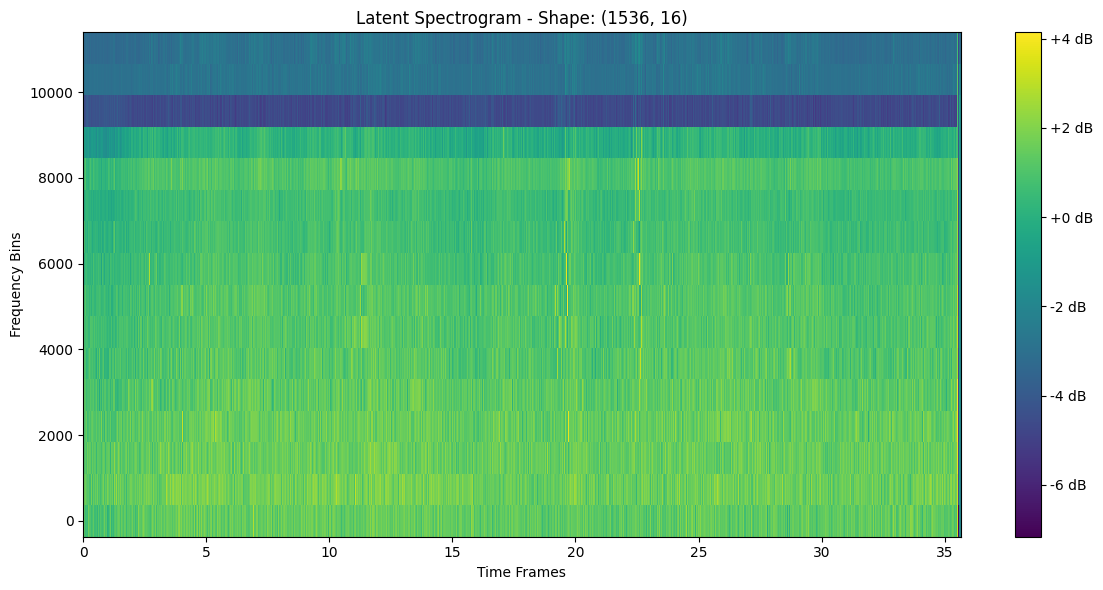

Latent stats - Min: -7.161, Max: 4.140, Mean: 0.192, Std: 1.871


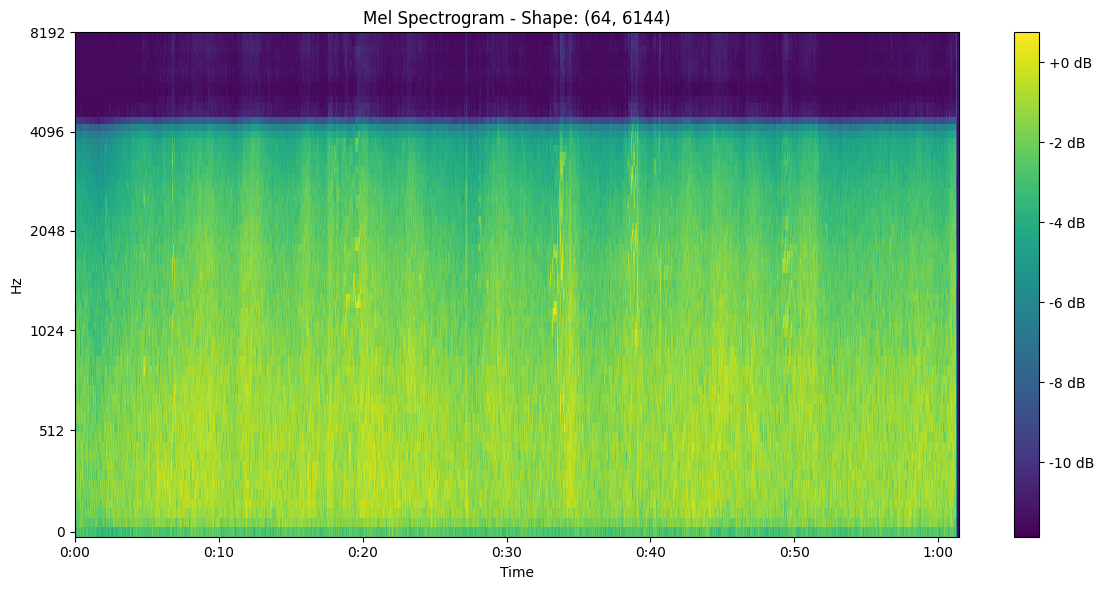

Mel stats - Min: -11.859, Max: 0.746, Mean: -4.061, Std: 3.739


In [ ]:
# VAE DECODER VRAM MEASUREMENT
# Get memory before VAE and reset peak tracker
memory_before_vae = torch.cuda.memory_allocated() / (1024 * 1024)
torch.cuda.reset_peak_memory_stats()

# Run VAE
start_time = time.time()
with torch.no_grad(): 
    mel_spectrogram = model.decode_first_stage(samples)
torch.cuda.synchronize()
vae_time = time.time() - start_time

# Get memory usage
isolated_peak = torch.cuda.max_memory_allocated() / (1024 * 1024)  # Convert to MiB
current_memory = torch.cuda.memory_allocated() / (1024 * 1024)  # Convert to MiB
isolated_cost = isolated_peak - memory_before_vae

print(f"VAE DECODER ISOLATED PEAK: {isolated_peak:.1f} MiB (cost: +{isolated_cost:.1f} MiB)")
print(f"VAE DECODER CURRENT MEMORY: {current_memory:.1f} MiB")
print(f"VAE TIME: {vae_time:.1f}s")
# print(torch.cuda.memory_summary())

plot_latent_spectrogram(samples, title="Latent Spectrogram")
plot_mel_spectrogram(mel_spectrogram, title="Mel Spectrogram", sr=sr)

In [ ]:
memory_before_vocoder = torch.cuda.memory_allocated() / (1024 * 1024)
torch.cuda.reset_peak_memory_stats()

start_time = time.time()
with torch.no_grad(): 
    waveform = model.mel_spectrogram_to_waveform(mel_spectrogram)[0]
torch.cuda.synchronize()
vocoder_time = time.time() - start_time

# Get memory usage
isolated_peak = torch.cuda.max_memory_allocated() / (1024 * 1024)  # Convert to MiB
current_memory = torch.cuda.memory_allocated() / (1024 * 1024)  # Convert to MiB
isolated_cost = isolated_peak - memory_before_vocoder

print(f"VOCODER ISOLATED PEAK: {isolated_peak:.1f} MiB (cost: +{isolated_cost:.1f} MiB)")
print(f"VOCODER CURRENT MEMORY: {current_memory:.1f} MiB")
print(f"VOCODER TIME: {vocoder_time:.1f}s")

ipd.display(ipd.Audio(waveform, rate=sr))
print(torch.cuda.memory_summary())

VOCODER ISOLATED PEAK: 5174.4 MiB (cost: +722.8 MiB)
VOCODER CURRENT MEMORY: 4451.6 MiB
VOCODER TIME: 0.4s


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   4451 MiB |   5174 MiB |  25048 GiB |  25044 GiB |
|       from large pool |   4318 MiB |   5041 MiB |  25028 GiB |  25024 GiB |
|       from small pool |    132 MiB |    132 MiB |     20 GiB |     20 GiB |
|---------------------------------------------------------------------------|
| Active memory         |   4451 MiB |   5174 MiB |  25048 GiB |  25044 GiB |
|       from large pool |   4318 MiB |   5041 MiB |  25028 GiB |

In [ ]:
import soundfile as sf

# Ensure waveform is a NumPy array and has the correct shape
waveform = waveform.squeeze()  # Remove batch dimension if present
if isinstance(waveform, torch.Tensor):
    waveform = waveform.cpu().numpy()  # Convert to NumPy array if it's a PyTorch tensor

# Save the generated audio to a file
output_path = "../output/generation"
os.makedirs(output_path, exist_ok=True)
filename = f"regular_Wind.wav"  # Simplify filename
sf.write(os.path.join(output_path, filename), waveform, sr)

print(f"Audio saved to {os.path.join(output_path, filename)}")

Audio saved to ../output/generation/regular_Ocean.wav
